# Wie lernt ein Neuronales Netz

https://bootcamp.codecentric.ai/

In diesem Notebook trainieren wir einen Classifier auf dem MNIST Datenatz. Viele finden diesen Datensatz inzwischen langweilige und "zu einfach" - aber für dieses Notebook ist er genau richtig. Wir brauchen ein kleines einfaches Dataset, um zeigen zu können, was die Basic-Steps zum Trainieren eines neuronalen Netzes sind. Würden wir einen schwierigen Datensatz verwenden, würden unsere vereinfachten Steps wahrscheinlich gar nicht mehr funktionieren.

Uns kommt es in diesem Notebook vor allem darauf an, wie der Trainingsloop aussieht. Während man in der fastai Library einfach nur `learn.fit()` aufrufen muss, werden wir hier (einen einfachen) Trainsingsloop selbst implementieren, um zu verstehen, was unter der Haube passiert.

Falls du dir die Slides aus dem Video noch einmal ansehen möchtest: https://codecentric.slides.com/omoser/neuronale-netze-und-deep-learning/#/25

### Beispiel mit PyTorch

Zunächst benötigte Libraries und Settings:

In [49]:
# Bilder innerhalb des Notebooks anzeigen
%matplotlib inline 

import torch
import torchvision
from torchvision import transforms
from matplotlib import pyplot


## Daten laden / vorbereiten

In [2]:
DATA_PATH = '/data/'

Wir verwenden die PyTorch Boardmittel und definieren:

- eine Reihe von Transformations (diese werden beim Laden der Daten durchgeführt, z.B. Data Augmentation oder Normalisierung)
- ein Trainings-Set 
- einen Loader für das Trainings-Set

(Wir definieren zunächst nur ein Trainings-Set ohne Validation-Set)

In [11]:
# Batch Size
bs = 128  

tfms = transforms.Compose([
       transforms.ToTensor(), 
       transforms.Lambda(lambda x: x.flatten())
]) 

train_set = torchvision.datasets.MNIST(DATA_PATH, download=True, 
                                       train=True, transform=tfms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs, 
                                           shuffle=True)

Wir schauen uns an welche Klassen im Dataset vorhanden sind:

In [12]:
classes = train_set.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Und nun lassen wir uns ein paar Beispiele anzeigen, damit wir wissen mit welchen Daten wir es zu tun haben:

In [17]:
def show_data_sample(data_loader, n=10, figsize=(20,10)):
    # configure plot output
    figure = pyplot.figure(figsize=figsize) 

    batch = iter(data_loader).next()
    images, labels = batch

    for i, img in enumerate(images):
        figure.add_subplot(n//5 + 1, 5, i+1)
        pyplot.axis('off')
        pyplot.title(classes[labels[i]])
        pyplot.imshow(img.view(-1, 28))
        if i == n-1: 
            break


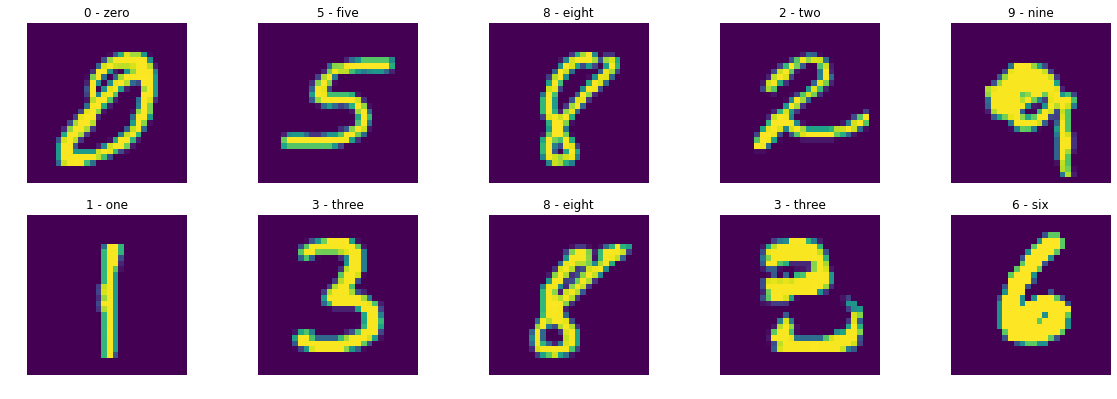

In [18]:
show_data_sample(train_loader, 10)

Wie groß ist unser Trainings-Set?!

In [19]:
print("Training Set", len(train_set))

Training Set 60000


## (simples) Model definieren

Wir definieren nun ein ähnliches neuronales Netz wie in "Was sind neuronale Netze" (https://codecentric.slides.com/omoser/neuronale-netze-und-deep-learning#/8).

Allerdings verwenden wir diesmal eine etwas andere Schreib-/Herangehensweise. In PyTorch werden neuronale Netze von torch.nn.Module abgeleitet. Im Konstruktor defininiert man welche Schichten man verwendet und die die Methode `def forward(self, x)` wird bei einem forward-pass des Modells aufgerufen. x ist dabei der Input also z.B. die Trainings-Daten.

Wieder haben wir eine Input Schicht von 28 x 28 = 784 Pixeln und eine Output-Schicht von 10 Klassen ("One Hot Encoded Vector" für Ziffern 0-9). 

In [20]:
class SuperSimpleNet(torch.nn.Module):
    def __init__(self):
        super(SuperSimpleNet, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 20), # 28x28 ist die Input Size
            torch.nn.ReLU(), 
            torch.nn.Linear(20, 10) # 10 ist die Output Size
        )
        
    def forward(self, x):
        out = self.layer(x)
        return out.sigmoid()
        

In [21]:
model = SuperSimpleNet()
model

SuperSimpleNet(
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)

Jetzt definieren wir unsere Loss-Funktion. Da wir eine Klassifikation in mehrere Klassen machen wollen, verwenden wir wieder die bestehende `torch.nn.CrossEntropyLoss()`

In [22]:
loss_func = torch.nn.CrossEntropyLoss()

Und nun definieren wir noch eine Funktion, um die Accuracy beim Training zu messen:

In [23]:
def accuracy(output, labels):
    # output ist ein tenor.size(10). Die Stelle bedeutet die hier die vorhergesagte Zahl 
    # Beispiel: output = [0, 0, 0.1, 0.9, ...] Die Stelle mit der größten Zahl (=torch.argmax) ist 4 - das heisst die Vorhersage wäre hier 4
    predictions = torch.argmax(output, dim=1)

    # jetzt schauen wir wo die Vorhersage stimmt (pred=label) und bilden den Durschnitt über den aktuellen Batch
    return (predictions == labels).float().mean()

Und jetzt implementieren wir einen (simplen) Trainings-Loop.

- wir definieren eine (statische) Learning Rate
- eine Epoche ist ein kompletter Durchlauf durchs Trainings-Set
- das Trainings-Set wird in Batches unterteilt 
- dann wird Vorhersage und Fehler bestimmt
- mit Backpropagation und SGD werden Paramater optimiert

Dies ist die "einfachst mögliche" Form von einem Trainings-Loop. Ein "modernes" großes/tiefes neuronales wird man damit nicht trainiert bekommen. 

Dazu benötigt man ein paar weitere "Tricks". Diese "Tricks" beeinflussen zum Beipiel dynamisch die Größe der Learning Rate. 

*Im Prinzip ist es aber das, was passiert, damit ein neuronales Netz lernt.*

In [47]:
lr = 0.01

def fit(epochs=1):
    for epoch in range(epochs):

        print("Epoch: ", epoch)
        
        # der Train Loader gibt teilt die gesamten Daten in Batches auf
        for i, batch in enumerate(train_loader):

            # ein Batch besteht aus Trainingsdaten und labels
            x_train, label = batch
            
            # wir setzen alle Gradients auf 0 (sonst verfälschen/beeinflussen diese die vorige Trainings-Runde)
            model.zero_grad()
            
            # wir verwenden unser Modell und machen eine Vorhersage mit den Traingsdaten dieses Batches
            pred = model(x_train)
            # wir ermitteln den Fehler mit der Loss Funktion (Vergleich Vorhersage mit Label)
            loss = loss_func(pred, label)

            # anhand des Fehlers machen wir eine Backpropagation
            # das PyTorch Framework errechnet die Gradients, die wir verwenden können
            # um unsere Parameter in "die richtige Richtung" anzupassen
            loss.backward()
            
            with torch.no_grad():
                # für alle Parameter im Modell (in unserem Fall 2 Weight-Matrizen)
                for param in model.parameters():
                    # optimiere die Parameter in die Richting des Gradients mit der Schrittweite "learning-rate"
                    param -= param.grad.data * lr
        
        # gib Loss und Accuracy vom letzten Batch aus
        print("Loss: ", loss.item(), "Accuracy: ", accuracy(pred, label).item())

        

Jetzt rufen wir unseren eigenen Trainings-Loop auf und trainieren für 10 Epochen (= wir arbeiten 10 x die gesamten Traingsdaten durch):

In [25]:
fit(10)

Epoch:  0
Loss:  2.233034133911133 Accuracy:  0.25
Epoch:  1
Loss:  2.1582396030426025 Accuracy:  0.5833333134651184
Epoch:  2
Loss:  2.061486005783081 Accuracy:  0.6979166865348816
Epoch:  3
Loss:  1.9634884595870972 Accuracy:  0.7395833134651184
Epoch:  4
Loss:  1.896990418434143 Accuracy:  0.7916666865348816
Epoch:  5
Loss:  1.8455305099487305 Accuracy:  0.8020833134651184
Epoch:  6
Loss:  1.8075557947158813 Accuracy:  0.8020833134651184
Epoch:  7
Loss:  1.7659879922866821 Accuracy:  0.8229166865348816
Epoch:  8
Loss:  1.7675213813781738 Accuracy:  0.8229166865348816
Epoch:  9
Loss:  1.751010537147522 Accuracy:  0.8333333134651184


Wir sehen, dass das neuronale Netz etwas "lernt". Der Loss wird tendenziell geringer und die Accuracy steigt. 

Während die Accuracy anfangs unter 0.5 lag (d.h. nur jede 2. Vorhersage ist richtig), geht die Accuracy nach 10 Epochen in Richtung 0.8 (d.h. 8 von 10 Vorhersagen sind richtig).

An dieser Stelle betrachten wir allerdings nur die Trainingsdaten (ohne Validation-Set). Wir merken also nicht wenn ein "Overfitting" passiert. 



### Zwischen-Fazit

Unsere selbst geschriebene fit() Funktion zeigt, wie ein neuronales Netz im Prinzip lernt. Wie schon angedeutet ist dies aber für komplexere Netze nicht ausreichend, damit ein neuronales Netz (in annehmbarer) Zeit zuverlässig lernen kann.

Wie wir im Beipiel mit dem "fruits Classifier" und fast.ai schon gesehen haben, musste man dort nur `learn.fit()` aufrufen. In diesem fastai-Trainings-Loop waren bereits viele Best-Practices implementiert. 

Wir schauen uns jetzt noch kurz an, wie man einen Trainings-Loop für komplexere Anwendungen mit PyTorch Boardmitteln implementieren könnte:

In [26]:
import torch.optim as optim

In [27]:
# wir nehmen hier Adam als Optimizer, es gibt aber auch SGD und viele mehr
optimizer = optim.Adam(model.parameters(), lr=lr)

In [28]:
def fit_better(n=1):
    for epoch in range(n):  
        for i, data in enumerate(train_loader):
            x_train, labels = data
            optimizer.zero_grad()

            # forward + backward + optimize
            pred = model(x_train)
            loss = loss_func(pred, labels)
            loss.backward()
            
            # im Prinzip ist bis hierhin alles wie vorher - die Anpassungen der Parameter ist aber im Schritt optimizer.step() zusammengefasst
            # hier passieren unter der Haube jetzt etwas smartere Anpassungen als in unserem einfachen Beispiel
            optimizer.step()
        print("Loss: ", loss.item(), "Accuracy: ", accuracy(pred, labels).item())
        


In [29]:
fit_better()

Loss:  1.5133062601089478 Accuracy:  0.9479166865348816


# Aufgaben

In unserem eigenen Trainings-Loop verwenden wir derzeit nur ein Trainings-Set (aber kein Validation-Set). So können wir nicht bemerken, ob unser Netz "overfittet".

1. Passe den Trainingsloop so an, dass zusätzlich zum train_loss auch ein validation_loss bestimmt wird. Du kannst dafür entweder das Trainingsset aufsplitten in ein Train/Vaild-Set oder du kannst in diesem Beispiel die MNIST Test-Daten dafür verwenden:

In [52]:
valid_set = torchvision.datasets.MNIST(DATA_PATH, download=True, 
                                       train=False, transform=tfms)

valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=bs, 
                                           shuffle=True)

# Tipp, so kannst du einen Batch Validierungs-Daten laden: 
# valid_batch = iter(valid_loader).next()
# x_valid, labels_valid = valid_batch

2. Visualisiere beide loss Kurven in einem Plot

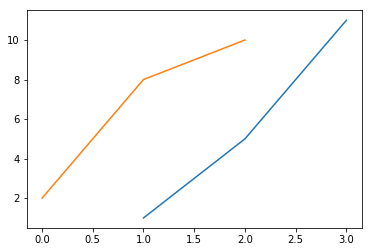

In [50]:
# Tipp, so könntest du Daten sammlen / visualisieren:
data = [1, 5, 11]
data2 = [2, 8, 10]
epochs = [1, 2, 3]
pyplot.plot(epochs, data, data2)

3. In dem Trainings-Loop wird der Loss und die Accuracy für den letzten Batch berechnet/ausgegeben. Ändere die Logik so, dass die Metriken jeweils für die Epoche berechnet werden.

In [51]:
# Tipp, Sammle alle Werte und Bilde dann den Durschnitt für eine Epoche